**关于该Notebook**

任务: 以沪深300数据集为例，使用scutquant包完成从原始数据到因子，再到拟合模型和回测的全过程。具体包括:  

(1)、使用**scutquant**(scutquant包下面的一个模块)和**alpha**构造目标值和因子，并自动完成特征工程和数据清洗(包括拆分数据集、填充和去除缺失值、标准化、截断异常值、重采样和降采样、特征筛选和正则化)  

(2)、使用**scutquant**一键建模(以lightgbm为例) 

(3)、使用**scutquant**的ic_ana计算IC、Rank IC和pearson相关系数等指标，并评价模型拟合情况(指标越高越好), IC的计算方式为  
 $$IC(t) = PearsonCorr(predict_{t}, y_{t})$$  
 其中, $PearsonCorr(x, y) = \frac{cov(x,y)}{\sqrt{\sigma_x * \sigma_y}}$, $predict_t$ 为t时刻所有资产的预测值序列(即截面上的预测值), 同理$y_t$ 为截面上的真实值
 
(4)、判断多因子在该模型下是否有效的t检验为 $t = ICIR * \sqrt{\Delta T}$, 其中$ICIR=\frac{\bar{IC}}{\sigma{IC}}$, $\Delta T$为时间间隔(例如测试集的天数). 该方法仅在IC分布为正态分布时成立(ic_ana会输出IC序列的分布图)  

(5)、使用**report**模块查看分组情况(按照每个time_tick的预测情况，对所有资产从高到低分成n组，并计算它们的累计平均收益率)。如果Group1到Group5呈现了明显的单调性(几条曲线交错很少, 且1~5由高到低呈现)则说明因子和模型的选股能力较强，因子较有效.  

5.1、其中, long-short为做多Group1(预测值最高)做空Group5(预测值最低)的累计收益，long-average为做多Group1并无差别做空资产池的累计收益(因为中国股市严格限制做空，因此long-short的收益难以实现，但是可以通过做空股指期货的做法实现套利, 而average对应的就是股指期货)，并给出预测的准确率($predict_{i,t}>=0$且$y_{i,t}>=0$或$predict_{i,t}<0$且$y_{i,t}<0$则为正确，否则为错误)  

(6)、使用**executor**模块执行回测, 需要在字典中写好策略和其它必要的参数, 并使用**report**模块报告回测结果  

In [1]:
# 导入需要用到的库
import pandas as pd
import scutquant.scutquant as q
from scutquant import alpha, report, executor

样例数据集只有基础的价量数据，以面板数据的形式呈现. 当需要额外数据构建因子时(例如需要构建市场因子Rm), 就需要读取supplemental data. 当补充数据为时序数据时，可以使用join_data函数将其合并到数据集中；当补充数据为各个股票的截面数据时，可以使用join_data_by_code按股票代码将数据合并到数据集中

In [2]:
# 读取数据
df = pd.read_csv("D:/Desktop/csidata.csv")
df["datetime"] = pd.to_datetime(df["datetime"])
df.set_index(["datetime", "instrument"], inplace=True)
df

open   high    low  close  pre_close  change  pct_chg  \
datetime   instrument                                                           
2006-01-04 000001.SZ    6.13   6.33   6.12   6.28       6.14    0.14   2.2800   
           000002.SZ    4.40   4.67   4.40   4.66       4.31    0.35   8.1200   
           000012.SZ    4.70   4.75   4.55   4.70       4.62    0.08   1.7300   
           000016.SZ    3.52   3.58   3.52   3.57       3.52    0.05   1.4200   
           000021.SZ    7.99   8.40   7.99   8.32       8.00    0.32   4.0000   
...                      ...    ...    ...    ...        ...     ...      ...   
2023-07-27 688363.SH   94.34  96.20  94.00  95.90      94.70    1.20   1.2672   
           688396.SH   55.25  56.25  54.92  55.36      54.92    0.44   0.8012   
           688561.SH   48.96  49.38  48.80  48.83      49.11   -0.28  -0.5701   
           688599.SH   36.40  37.29  36.36  36.39      36.61   -0.22  -0.6009   
           688981.SH   50.01  50.14  49.20  49.39      50.15   -0.76  -1.5155   

                             amount     volume  
datetime   instrument                           
2006-01-04 000001.SZ    96989.00660  154450.68  
           000002.SZ   175187.06570  389310.43  
           000012.SZ    18863.86250   40399.61  
           000016.SZ     5131.87930   14426.65  
           000021.SZ    27657.17080   33526.60  
...                             ...        ...  
2023-07-27 688363.SH   276386.76000   28957.40  
           688396.SH   218456.02400   39268.57  
           688561.SH    76213.86113   15532.40  
           688599.SH   456467.83070  124308.87  
           688981.SH   812613.12370  163390.62  

[1240545 rows x 9 columns]

**关于目标值:** 为了避免数据泄露和其它各种问题，我们构建的目标值应尽量与已知数据无关(即$y_t$无法用已知的数据${X_t, X_{t-1}, ...}$计算得到). 这里我们选择$label = \frac{close_{-2}}{close_{-1}} - 1$, 即T时刻需要预测的目标值是T+2相对于T+1的收益率, 现实意义是在今天(T)作出预测, 并在明天(T+1)以收盘价开仓, 后天(T+2)以收盘价平仓  

**关于因子:** 参考alpha模块中的make_factors()和alpha360(), 前者主要为技术指标, 后者是原始量价数据的滞后项除单位, 目的是让模型在张成的360维空间中自行发掘因子

In [3]:
# 构造目标值
df["label"] = df["pct_chg"].groupby("instrument").shift(-2) / 100
df = df.dropna() 

In [4]:
X = alpha.qlib158(df)
X = pd.concat([X, df[["label"]]], axis=1)
X

open1     open2     open3     open4     open5  \
datetime   instrument                                                     
2006-01-04 000001.SZ        NaN       NaN       NaN       NaN       NaN   
           000002.SZ        NaN       NaN       NaN       NaN       NaN   
           000012.SZ        NaN       NaN       NaN       NaN       NaN   
           000016.SZ        NaN       NaN       NaN       NaN       NaN   
           000021.SZ        NaN       NaN       NaN       NaN       NaN   
...                         ...       ...       ...       ...       ...   
2023-07-25 688363.SH   0.998085  0.962660  0.961277  0.953936  0.947979   
           688396.SH   0.986727  0.979818  0.985455  0.981818  0.985273   
           688561.SH   0.973039  0.970809  0.991689  1.003446  1.012568   
           688599.SH   0.986260  0.989283  1.002748  1.006046  1.016488   
           688981.SH   0.982118  0.984730  0.991159  0.994575  0.984529   

                         close1    close2    close3    close4    close5  ...  \
datetime   instrument                                                    ...   
2006-01-04 000001.SZ        NaN       NaN       NaN       NaN       NaN  ...   
           000002.SZ        NaN       NaN       NaN       NaN       NaN  ...   
           000012.SZ        NaN       NaN       NaN       NaN       NaN  ...   
           000016.SZ        NaN       NaN       NaN       NaN       NaN  ...   
           000021.SZ        NaN       NaN       NaN       NaN       NaN  ...   
...                         ...       ...       ...       ...       ...  ...   
2023-07-25 688363.SH   0.992553  0.998085  0.959362  0.953617  0.958191  ...   
           688396.SH   0.992727  0.987091  0.977091  0.978909  0.989273  ...   
           688561.SH   0.985404  0.974458  0.976485  0.992905  0.994121  ...   
           688599.SH   0.971146  0.983787  0.990932  0.994504  1.009893  ...   
           688981.SH   0.984529  0.984529  0.990356  0.987543  0.998594  ...   

                        vsump10   vsump20   vsump30   vsump60    vsumn5  \
datetime   instrument                                                     
2006-01-04 000001.SZ        NaN       NaN       NaN       NaN       NaN   
           000002.SZ        NaN       NaN       NaN       NaN       NaN   
           000012.SZ        NaN       NaN       NaN       NaN       NaN   
           000016.SZ        NaN       NaN       NaN       NaN       NaN   
           000021.SZ        NaN       NaN       NaN       NaN       NaN   
...                         ...       ...       ...       ...       ...   
2023-07-25 688363.SH   0.151169  0.067856 -0.234478 -0.047606 -0.242995   
           688396.SH   0.014767 -0.099715 -0.278204 -0.085300 -0.033904   
           688561.SH  -0.097845 -0.065561 -0.088517 -0.032193  0.307803   
           688599.SH   0.060621 -0.044404 -0.141937 -0.018149 -0.046496   
           688981.SH  -0.022692 -0.010020 -0.058739 -0.073201  0.429199   

                        vsumn10   vsumn20   vsumn30   vsumn60     label  
datetime   instrument                                                    
2006-01-04 000001.SZ        NaN       NaN       NaN       NaN  0.014200  
           000002.SZ        NaN       NaN       NaN       NaN -0.006400  
           000012.SZ        NaN       NaN       NaN       NaN  0.000000  
           000016.SZ        NaN       NaN       NaN       NaN  0.002700  
           000021.SZ        NaN       NaN       NaN       NaN -0.003600  
...                         ...       ...       ...       ...       ...  
2023-07-25 688363.SH  -0.151169 -0.067856  0.234478  0.047606  0.012672  
           688396.SH  -0.014767  0.099715  0.278204  0.085300  0.008012  
           688561.SH   0.097845  0.065561  0.088517  0.032193 -0.005701  
           688599.SH  -0.060621  0.044404  0.141937  0.018149 -0.006009  
           688981.SH   0.022692  0.010020  0.058739  0.073201 -0.015155  

[1238773 rows x 150 columns]

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1238773 entries, (Timestamp('2006-01-04 00:00:00'), '000001.SZ') to (Timestamp('2023-07-25 00:00:00'), '688981.SH')
Columns: 150 entries, open1 to label
dtypes: float64(150)
memory usage: 1.4+ GB
None
X_mis= 1.3728966754468603
clean dataset done 

split data done 

label norm done 

The distribution of y_train:


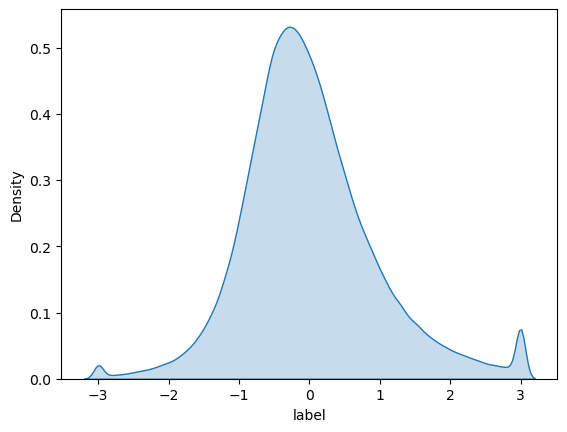

The distribution of y_valid:


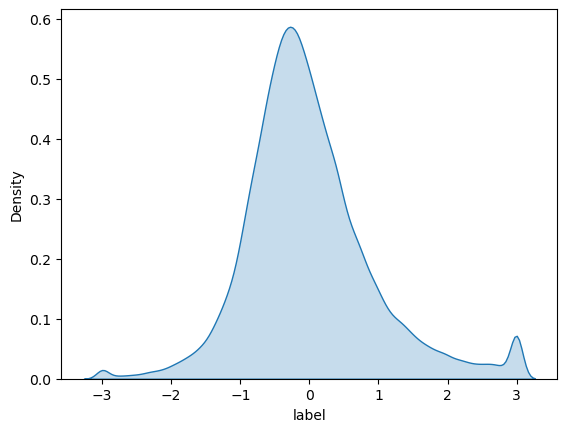

The distribution of y_test:


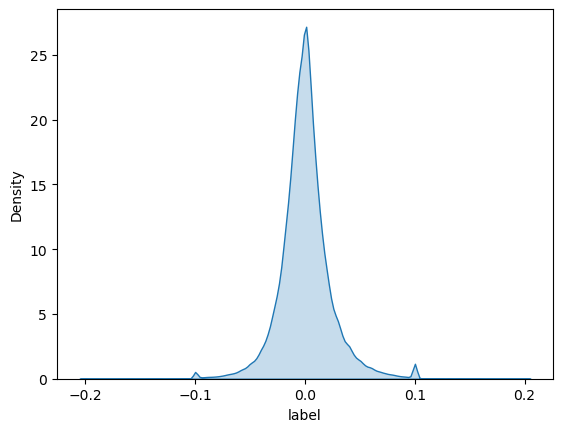

norm data done 

all works done 



In [5]:
split_params = {
    "test_start_date": "2017-01-01",
    "split_method": "split_by_date",
    "split_kwargs":{
        "train_end_date": "2014-12-31",
        "valid_end_date": "2016-12-31"
    }
}
# 按split_params拆分出训练集、验证集和测试集, 并在截面上进行标准化
result = q.auto_process(X, "label", groupby="instrument", split_params=split_params, select=False, orth=False, clip=5)

X_train, y_train, X_valid, y_valid = result["X_train"], result["y_train"], result["X_valid"], result["y_valid"]
X_test, y_test, ymean, ystd = result["X_test"], result["y_test"], result["ymean"], result["ystd"]

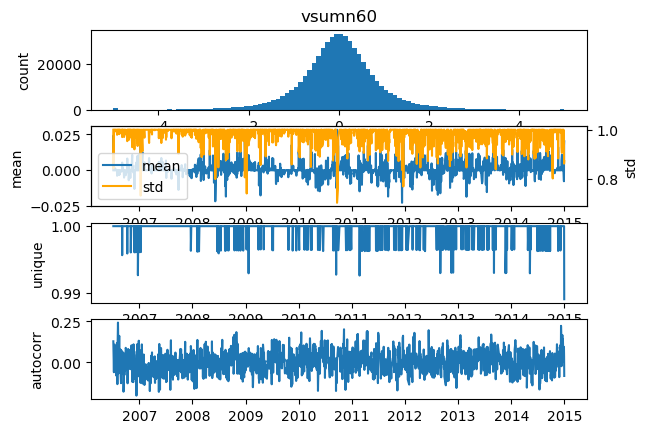

In [6]:
# 选择一个因子, 并对其可视化 (此步骤非必要)
report.single_factor_ana(X_train["vsumn60"])

In [7]:
# 拟合模型
model = q.auto_lgbm(X_train, y_train, X_valid, y_valid, early_stopping=50)

pred = model.predict(X_test)
pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += ymean.groupby("datetime").shift(2).fillna(0.0002)  # 为防止数据泄露, 使用滞后2阶的mean和std还原预测值
pred["predict"] *= ystd.groupby("datetime").shift(2).fillna(0.0189)
pred.describe()

Training until validation scores don't improve for 50 rounds
[20]	train's l2: 0.890718	valid's l2: 0.858224
[40]	train's l2: 0.887853	valid's l2: 0.857426
[60]	train's l2: 0.88577	valid's l2: 0.856997
[80]	train's l2: 0.88397	valid's l2: 0.856741
[100]	train's l2: 0.882391	valid's l2: 0.856523
[120]	train's l2: 0.880925	valid's l2: 0.856414
[140]	train's l2: 0.879588	valid's l2: 0.856321
[160]	train's l2: 0.878394	valid's l2: 0.856196
[180]	train's l2: 0.877143	valid's l2: 0.85618
[200]	train's l2: 0.875972	valid's l2: 0.856152
[220]	train's l2: 0.874785	valid's l2: 0.85613
[240]	train's l2: 0.873637	valid's l2: 0.856108
[260]	train's l2: 0.872432	valid's l2: 0.856158
[280]	train's l2: 0.871291	valid's l2: 0.856134
Early stopping, best iteration is:
[241]	train's l2: 0.873581	valid's l2: 0.856102


,predict
count,444883.000000
mean,-0.000175
std,0.001538
min,-0.008647
25%,-0.001112
50%,-0.000126
75%,0.000826
max,0.006830


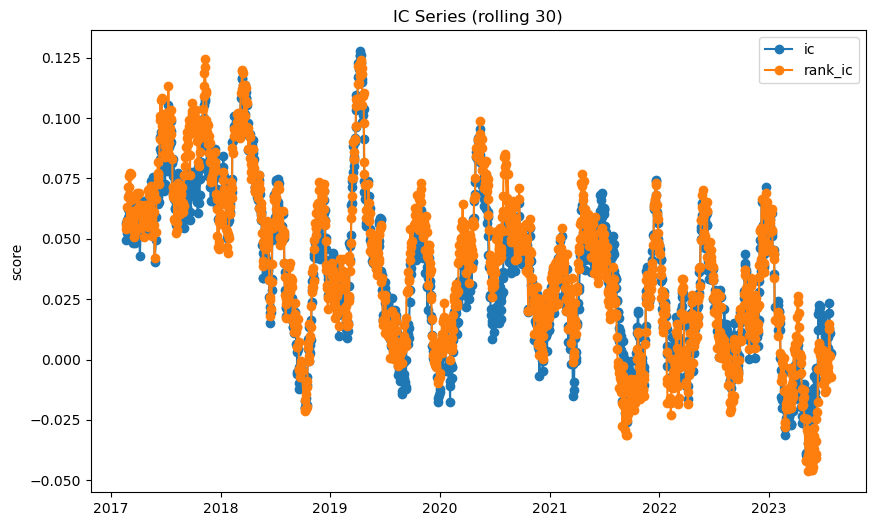

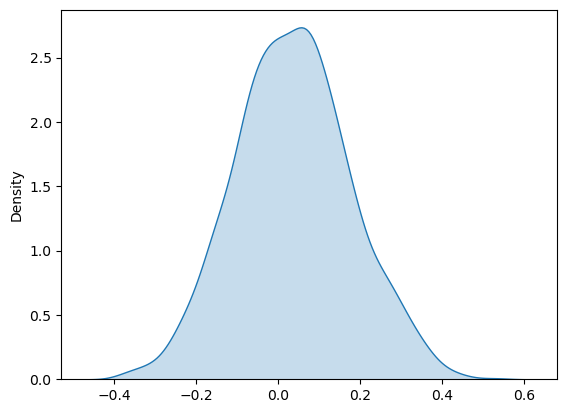

ic= 0.03544404860743971 icir= 0.2514959758379861 rank_ic= 0.03749250273255365 rank_icir= 0.2584840511279637


0.0288885899367673

In [8]:
# 使用IC评判拟合优度
ic, icir, rank_ic, rank_icir = q.ic_ana(pred, y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred["predict"], y_test)
r

In [9]:
# 以下为回测部分
# 将预测值处理成回测需要的格式(需要知道预测值"predict", 交易价格price和交易量volume)
df_test = df[df.index.isin(pred.index)]
pred = executor.prepare(pred, df_test, price='close', volume='volume', real_ret=y_test)

Accuracy of Prediction: 0.5304427670578068


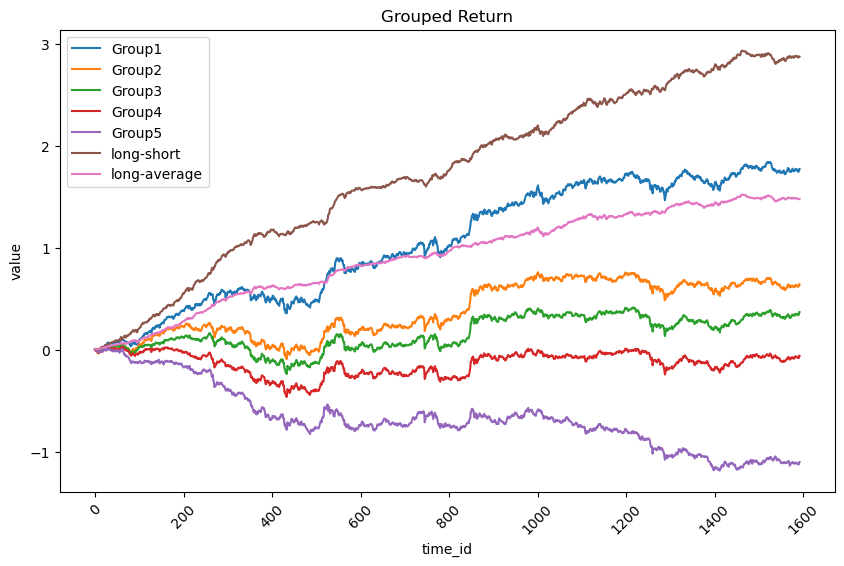

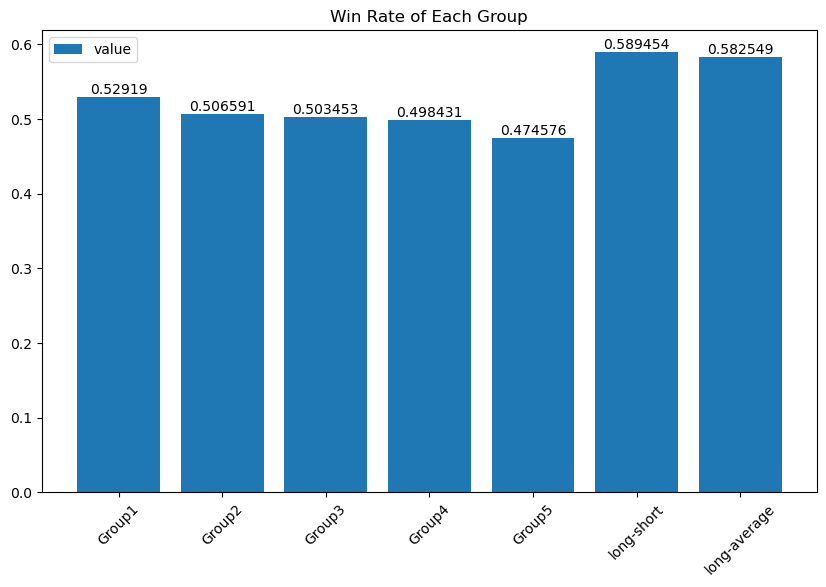

In [10]:
# 如果出现明显的分层, 则说明因子有良好的选股能力
report.group_return_ana(pred, y_test)

目前测得的策略容量以1亿(或者更少)为佳

In [11]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "TopKStrategy",  # 做多预测值前20%股票, 做空后20%的股票. 自动平仓
        "kwargs": {
            "k": 0.2,
            "auto_offset": False,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": False,  # =True时，只做多不做空(在A股做空有一定的难度)
            "short_volume": 500, # 融券做空的数量
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 0.05  # 手数随可用资金而改变，最大不会超过股票当天成交量的1%(例如T+1时下单，下单手数不会超过T时成交量的1%)
        }
    },
    "account": None, # 使用默认账户, 即初始资金为1亿, 无底仓 (注意策略容量！)
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0015,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)  # verbose=1时，按时间输出买卖指令

Annualized Return: 0.048954801706541096
Annualized Volatility: 0.07166804252811784
Annualized Return(Benchmark): 0.028674838511351997
Annualized Volatility(Benchmark): 0.05762002648796703 

Cumulative Rate of Return: 0.3527342080269764
Cumulative Rate of Return(Benchmark): 0.19568075764257875
Cumulative Excess Rate of Return: 0.15705345038439766 

Max Drawdown: -0.22443063092583931
Max Drawdown(Benchmark): -0.34029993811648745
Max Drawdown(Excess Return): -0.12691216696742044 

Sharpe Ratio: 1.5962859549053179
Sortino Ratio: 5.335206787455649
Information Ratio: 1.0318980935081479 

Beta: 1.0919666876324716
Alpha: 0.17657853503827173
Epsilon: 0.08627521250855257
Profitable Days(%): 0.9077212806026366


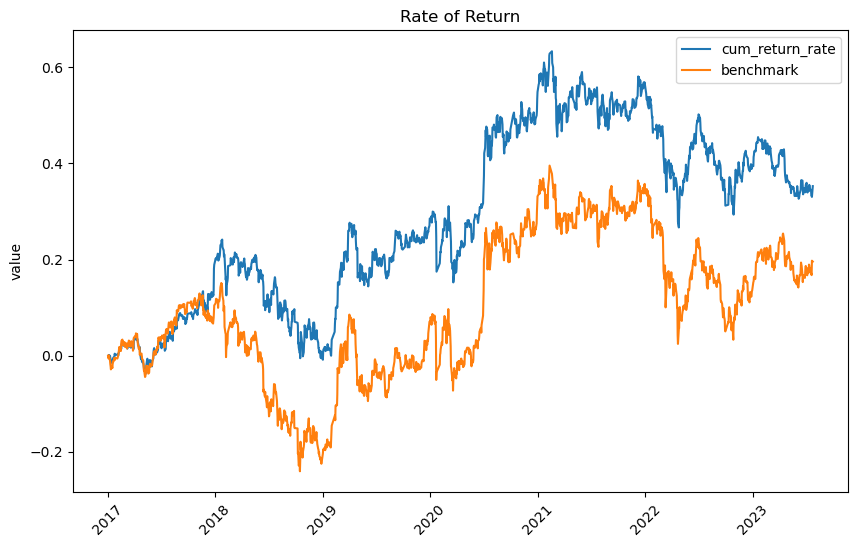

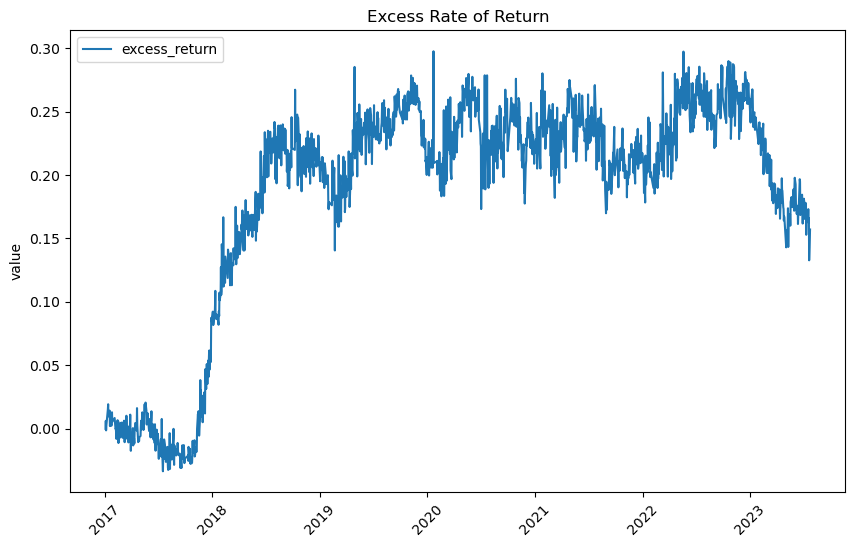

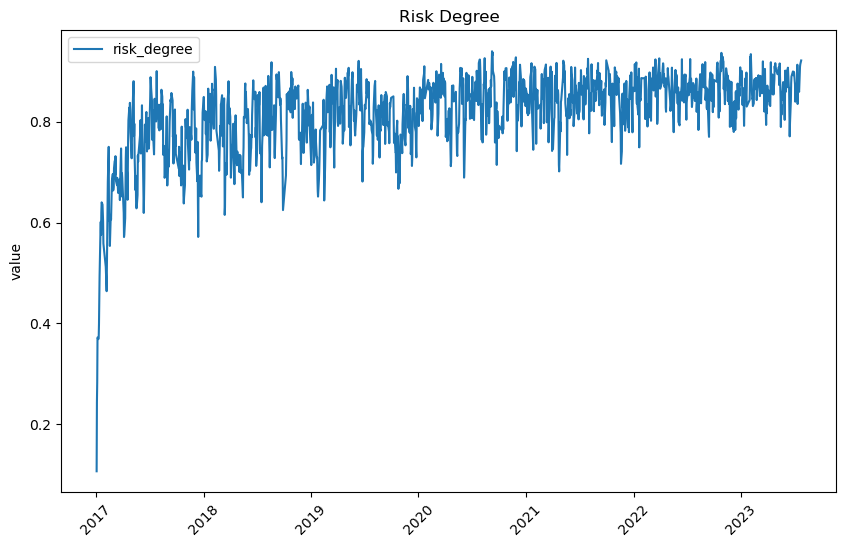

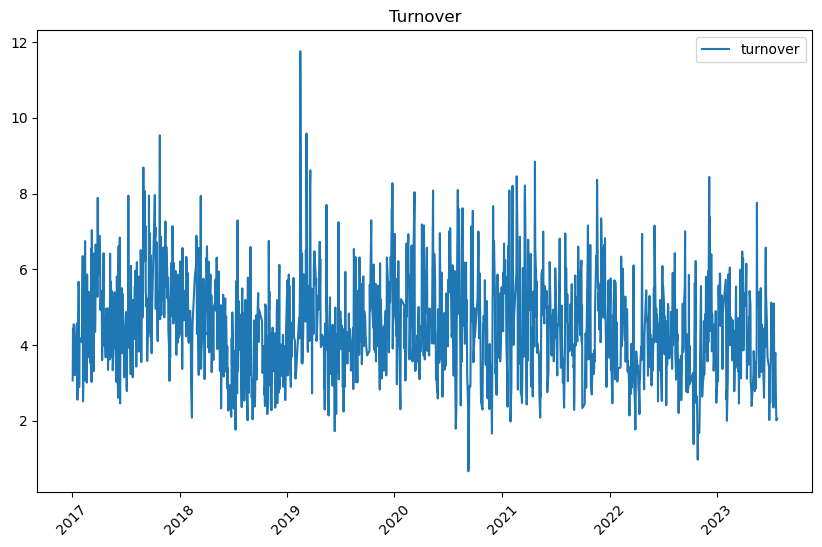

In [12]:
# 报告回测结果
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=1, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节

In [13]:
# user_account.buy_hist # 查看历史上所有买单